Ngưỡng tối ưu λ = 0.3922 (sai 1/22 mẫu)


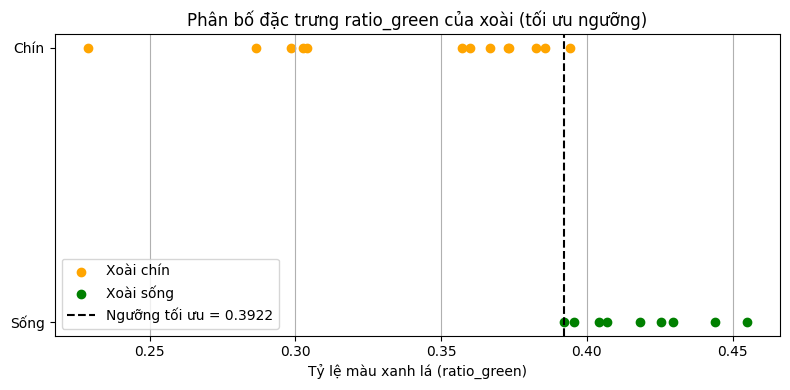

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# === Đường dẫn dataset (ảnh xoài đã tách nền) ===
base_dir = "/media/pphong/D:/ML & DL/ML/pred_mango/image_tachnen"

# Lưu giá trị ratio_green theo nhãn
green_ratios = {"chin": [], "song": []}

# === TÍNH ratio_green CHO TỪNG ẢNH ===
for label in ["chin", "song"]:
    folder_path = os.path.join(base_dir, label)
    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img = Image.open(os.path.join(folder_path, fname)).convert("RGB")
        img_np = np.array(img)

        # Bỏ nền đen
        mask = np.any(img_np > [0, 0, 0], axis=-1)

        R = img_np[:, :, 0][mask]
        G = img_np[:, :, 1][mask]
        B = img_np[:, :, 2][mask]

        if R.size > 0:
            sumR = np.sum(R)
            sumG = np.sum(G)
            sumB = np.sum(B)
            ratio_green = sumG / (sumR + sumG + sumB)
            green_ratios[label].append(ratio_green)

# === GỘP DỮ LIỆU VÀ NHÃN ===
ratios = np.array(green_ratios["chin"] + green_ratios["song"])
labels = np.array([1]*len(green_ratios["chin"]) + [0]*len(green_ratios["song"]))  # 1=chín, 0=sống

# === TÌM NGƯỠNG TỐI ƯU (minimize classification error) ===
sorted_ratios = np.sort(ratios)
best_lambda = None
min_error = 1e9

for t in sorted_ratios:
    preds = (ratios < t).astype(int)   # nếu ratio nhỏ → chín, lớn → sống
    error = np.sum(preds != labels)
    if error < min_error:
        min_error = error
        best_lambda = t

lamda = best_lambda
print(f"Ngưỡng tối ưu λ = {lamda:.4f} (sai {min_error}/{len(ratios)} mẫu)")

# === VẼ BIỂU ĐỒ ===
plt.figure(figsize=(8,4))
plt.scatter(green_ratios["chin"], [1]*len(green_ratios["chin"]),
            color="orange", label="Xoài chín")
plt.scatter(green_ratios["song"], [0]*len(green_ratios["song"]),
            color="green", label="Xoài sống")

plt.axvline(x=lamda, color='black', linestyle='--', label=f'Ngưỡng tối ưu = {lamda:.4f}')
plt.yticks([0,1], ["Sống","Chín"])
plt.xlabel("Tỷ lệ màu xanh lá (ratio_green)")
plt.title("Phân bố đặc trưng ratio_green của xoài (tối ưu ngưỡng)")
plt.legend()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()



KẾT QUẢ PHÂN LOẠI ẢNH TEST DỰA TRÊN ratio_green:
------------------------------------------------------------
18.png                     ratio_green = 0.4181  →  Dự đoán: sống
22.png                     ratio_green = 0.3857  →  Dự đoán: chín


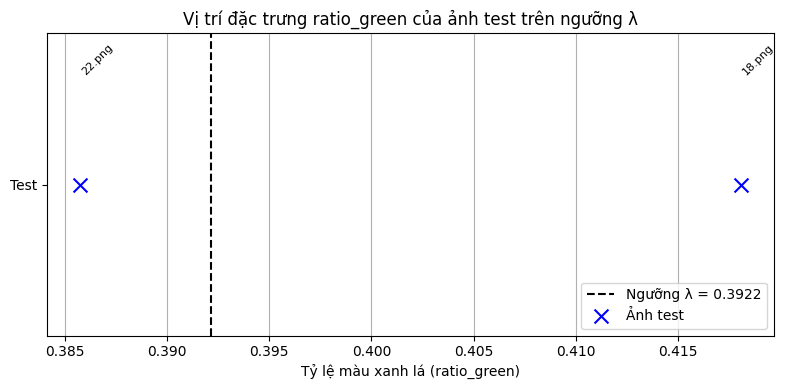

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# === ĐƯỜNG DẪN ===
test_dir = "/media/pphong/D:/ML & DL/ML/pred_mango/image_test"

# === BIẾN LƯU KẾT QUẢ ===
test_green_ratios = []
test_labels = []
test_files = []

# === TÍNH ratio_green CHO ẢNH TEST ===
for fname in os.listdir(test_dir):
    if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    # Đọc ảnh test và chuyển RGB
    img = Image.open(os.path.join(test_dir, fname)).convert("RGB")
    img_np = np.array(img)

    # Mask bỏ nền đen
    mask = np.any(img_np > [0, 0, 0], axis=-1)

    # Tách các kênh RGB
    R = img_np[:, :, 0][mask]
    G = img_np[:, :, 1][mask]
    B = img_np[:, :, 2][mask]

    if R.size > 0:
        sumR = np.sum(R)
        sumG = np.sum(G)
        sumB = np.sum(B)
        ratio_green = sumG / (sumR + sumG + sumB)
        test_green_ratios.append(ratio_green)
        test_files.append(fname)

        # Phân loại dựa vào ngưỡng λ
        if ratio_green >= lamda:
            test_labels.append("sống")  # Nhiều xanh → xoài sống
        else:
            test_labels.append("chín")  # Ít xanh → xoài chín

# === IN KẾT QUẢ PHÂN LOẠI ===
print("\nKẾT QUẢ PHÂN LOẠI ẢNH TEST DỰA TRÊN ratio_green:")
print("-" * 60)
for fname, ratio, label in zip(test_files, test_green_ratios, test_labels):
    print(f"{fname:<25}  ratio_green = {ratio:.4f}  →  Dự đoán: {label}")

# === VẼ BIỂU ĐỒ TEST TRÊN NGƯỠNG λ ===
plt.figure(figsize=(8,4))
plt.axvline(x=lamda, color='black', linestyle='--', label=f'Ngưỡng λ = {lamda:.4f}')
plt.scatter(test_green_ratios, [0.5]*len(test_green_ratios),
            color="blue", marker="x", s=100, label="Ảnh test")

for i, fname in enumerate(test_files):
    plt.text(test_green_ratios[i], 0.52, fname, fontsize=8, rotation=45)

plt.yticks([0.5], ["Test"])
plt.xlabel("Tỷ lệ màu xanh lá (ratio_green)")
plt.title("Vị trí đặc trưng ratio_green của ảnh test trên ngưỡng λ")
plt.legend()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()
